In [2]:
import os
import pandas as pd
import numpy as np

## Loading data (HR, MBP)

In [ ]:
# loading vital data
file_path = '../Preprocess/vital_to_np'

df_preprocess = pickle.load(open('../Preprocess/cache/preprocess/df_preprocess', 'rb'))
caseid_test = pickle.load(open('../DL_model/caseid_test', 'rb'))


dHR, dMBP = [], []
for caseid in caseid_test:
    vals = np.load(f'{file_path}/{caseid}.npz')
    
    
    eMBP = vals['eMBP']
    nMBP = vals['nMBP']
    eHR = vals['eHR']
    nHR = vals['nHR']
    
    for i in range(n_aug):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE
        
        dMBP = np.nanmean(eMBP[start_idx:end_idx]) - np.nanmean(nMBP)
        
        
    
    
    
    (vals('eMBP') - vals('nMBP')) / vals('nMBP')

## Loading input

## Loading model

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  

In [4]:
from keras.models import model_from_json


load_path = '../DL_model/randomSearch/CISA/CNN_4layers_Reg_1fold_test200'
load_path+='/mae0.051_rmse0.074_batch=512,c1=64,c2=128,c3=128,c4=256,filt1=3,filt2=7,filt3=3,filt4=7,str1=1,str2=1,str3=2,str4=1, conv_double=True,globalpool=ave,dropout=0.5,dnodes=8,dropout=0'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model.load_weights(load_weight_path)
print('done')

loading model...

2022-01-18 13:37:42.899655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 13:37:44.702445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30979 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0


done
loading weights...done


## Model Evaluation - test set

In [10]:
y_pred

array([-7.0780516e-05, -5.3018332e-05,  6.4469142e+00, ...,
        5.3802133e-04,  5.7008862e-04,  5.8081746e-04], dtype=float32)

train set auroc: 1.000000,  train set auprc: 1.000000


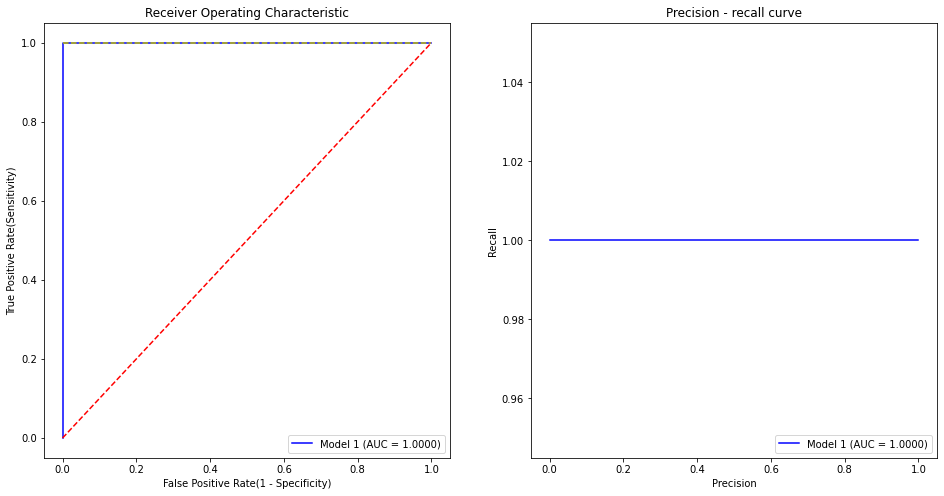

In [9]:
# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 120

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
cisa_test = np.load(input_path+'cisa_test.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model.predict(x_test).flatten()
cisa_test_bin = cisa_test > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(cisa_test_bin, y_pred/10)
precision1, recall1, _ = precision_recall_curve(cisa_test_bin, y_pred/10)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('train set auroc: {:.6f},  train set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

## Model Evaluation - train set

train set auroc: 1.000000,  train set auprc: 1.000000


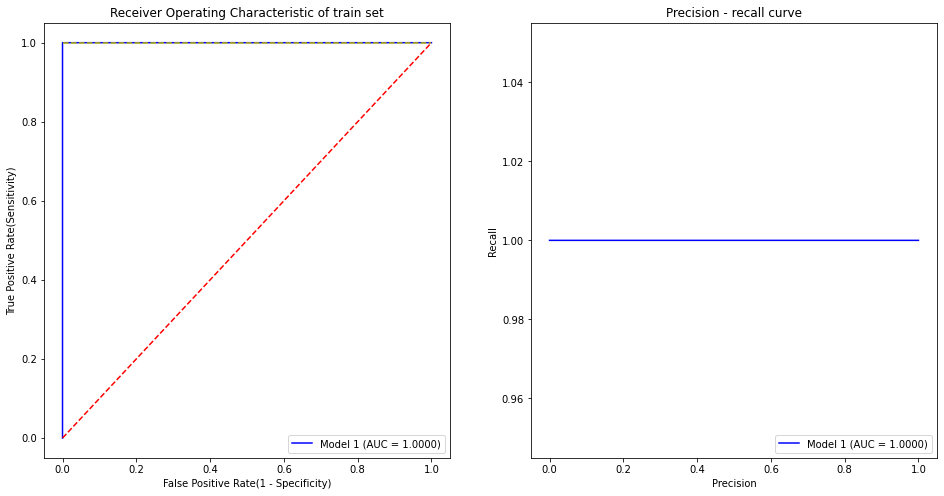

In [11]:
# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 120

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
cisa_train = np.load(input_path+'cisa_train.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model.predict(x_train).flatten()
cisa_train_bin = cisa_train > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(cisa_train_bin, y_pred/10)
precision1, recall1, _ = precision_recall_curve(cisa_train_bin, y_pred/10)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('train set auroc: {:.6f},  train set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic of train set')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

## TSS

loading model...done
loading weights...done
train set auroc: 0.782940,  train set auprc: 0.578042


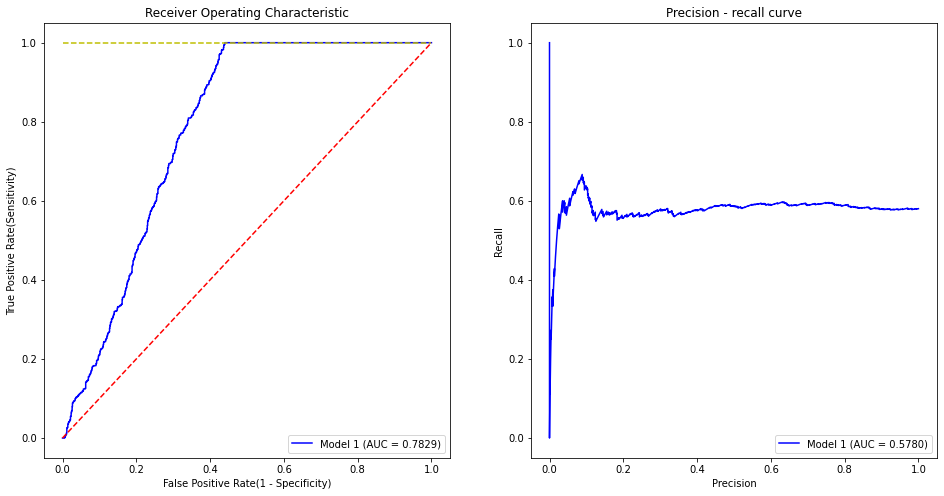

In [15]:
from keras.models import model_from_json


load_path = '../DL_model/randomSearch/TSS/CNN_4layers_Reg_1fold_test300'
load_path+='/mae0.096_rmse0.138_batch=512,c1=32,c2=128,c3=0,c4=0,filt1=5,filt2=5,filt3=0,filt4=0,str1=1,str2=1,str3=0,str4=0, conv_double=False,globalpool=max,dropout=0.5,dnodes=32,dropout=0'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model2 = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model2.load_weights(load_weight_path)
print('done')


# loading input
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 120

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
tss_test = np.load(input_path+'tss_test.npz')['arr_0']


from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

# model predict
y_pred = loaded_model2.predict(x_test).flatten()
tss_test_bin = tss_test > 0

# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(tss_test_bin, y_pred/10)
precision1, recall1, _ = precision_recall_curve(tss_test_bin, y_pred/10)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('train set auroc: {:.6f},  train set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

In [19]:
tss_test = np.load(input_path+'tss_test.npz')['arr_0']
tss_train = np.load(input_path+'tss_train.npz')['arr_0']

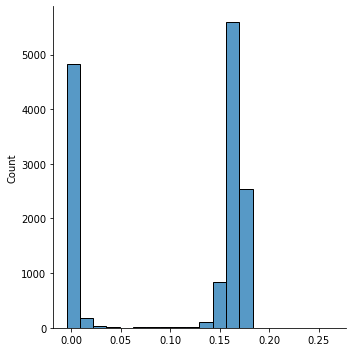

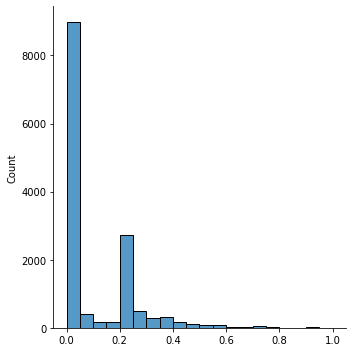

In [24]:
import seaborn as sns

sns.displot(loaded_model2.predict(x_train).flatten(), bins=20)
sns.displot(tss_train[tss_train<1], bins=20)

# Plotting ROC curve

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, r2_score
import matplotlib.pyplot as plt


false_positive_rate, true_positive_rate, threshold = roc_curve(y1, x_HR)
roc_auc_HR = auc(false_positive_rate, true_positive_rate)
print('HR test set auroc:', roc_auc_HR)

false_positive_rate, true_positive_rate, threshold = roc_curve(y2, x_MBP)
roc_auc_MBP = auc(false_positive_rate, true_positive_rate)
print('MBP test set auroc:', roc_auc_MBP)

# plotting
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve of MBP, HR')
plt.legend(loc="lower right")
plt.show()